In [34]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
import importlib
import pandas as pd
import audio_to_image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten,MaxPooling2D,GlobalAveragePooling2D, BatchNormalization,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
importlib.reload(audio_to_image)
from audio_to_image import *

In [7]:
filepath="/home/saadyaq/SE/Python/emotion_detector/data/raw/SPEECH_RECOGNITION/audio_speech_actors_01-24/Actor_18/03-01-04-01-02-02-18.wav"
img = audio_to_mel_array(filepath)
print("Shape avant padding :", img.shape)

img_padded = pad_spectrogram(img, target_width=143)
print("Shape après padding :", img_padded.shape)

Shape avant padding : (128, 157, 1)
Shape après padding : (128, 143, 1)


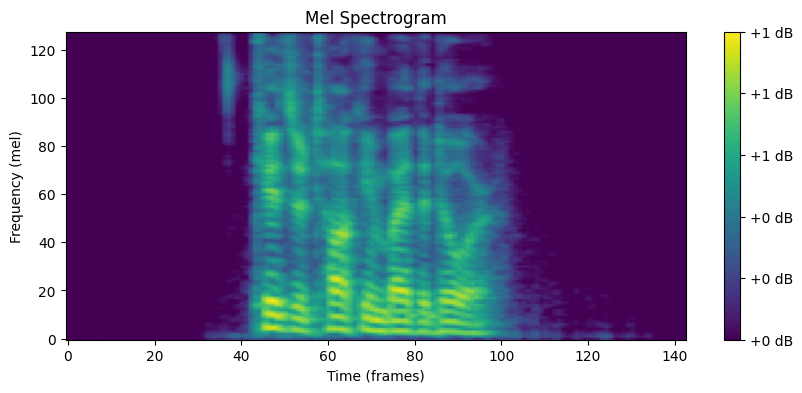

In [11]:
img=show_mel_image(img)
img

In [11]:
df=pd.read_csv("/home/saadyaq/SE/Python/emotion_detector/data/metadata.csv")
X,y=[],[]

In [ ]:
for idx,row in df.iterrows():
    filepath=row['path']
    label=row['emotion']

    try:
        img=audio_to_mel_array(filepath)
        img=pad_spectrogram(img,target_width=143)
        if img.shape==(128, 143,1):
            X.append(img)
            y.append(label)
        else:
            print(f"Skipping {filepath} due to shape mismatch: {img.shape}")
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
    
X=np.array(X)
y=np.array(y)

np.save("../data/X_spectro.npy", X)
np.save("../data/y_spectro.npy", y)

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()


In [26]:
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("Nombre de classes :", y_train.shape[1])


y_train shape: (1047, 8)
y_test shape: (262, 8)
Nombre de classes : 8


In [ ]:
num_classes = y_train.shape[1]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 143, 1)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),

    # Remplace Flatten par GlobalAveragePooling2D pour réduire les paramètres
    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 126, 141, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 126, 141, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 124, 139, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 124, 139, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,496 (91.78 KB)

 Trainable params: 23,496 (91.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.1557 - loss: 2.0723

In [29]:
import collections
collections.Counter(y)


Counter({np.str_('angry'): 189,
         np.str_('disgust'): 188,
         np.str_('calm'): 184,
         np.str_('sad'): 183,
         np.str_('happy'): 175,
         np.str_('fearful'): 159,
         np.str_('surprised'): 152,
         np.str_('neutral'): 79})

In [28]:
print("Exemple d’étiquette encodée (y_train[0]) :", y_train[0])
print("Somme des vecteurs :", [np.sum(row) for row in y_train[:5]])
print(np.unique(y))  # Avant encodage
y_pred = model.predict(X_test)
print(np.argmax(y_pred, axis=1)[:10])


Exemple d’étiquette encodée (y_train[0]) : [0. 0. 0. 1. 0. 0. 0. 0.]
Somme des vecteurs : [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]
['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
[2 2 2 2 2 2 2 2 2 2]
